In [1]:
import glob
import pickle
import seaborn as sns
import pandas as pd
from metrics import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import spatial
from data import one_hot
import numpy as np

In [2]:
# load RSA values of final iteration
def RSA(paths, metric="loss"):
    
    results = {}
    for path in paths:
        results[path] = {}
        for m in glob.glob(path + "/*/*.pkl"):

            seed = m.split('/')[2]
            if seed not in results[path]:
                results[path][seed] = {}

            it = m.split('_')[-1].split('.')[0]

            if it == 'metrics':
                continue

            iteration = int(it)
            
            # get the 

            results[path][seed][iteration] = pickle.load(open(m, 'rb'))
                
    return results

# load generalization scores
def load_metrics(path):
    """
        This function loads metrics at the end of an experiment
    """

    # load the data
    seed_folders = glob.glob(f"{path}/*")

    # save results
    generalize_result = {}
    train_result = {}

    # run through all seed
    for s in seed_folders:

        # get seed index
        seed = s.split("/")[-1]
        
        # make sure to ignore the rsa analysis for now
        if seed == 'rsa_analysis.pkl':
            continue

        # get all metric files
        metric_files = glob.glob(s + "/*.pkl")

        for file in metric_files:

            # load files
            m1 = pickle.load(open(file, "rb"))

            # check if file is generalize or train metric
            if file.find('generalize') == -1:
                if file.find('10000') != -1:
                    train_result[seed] = m1
            else:
                generalize_result[seed] = m1                

    return train_result, generalize_result



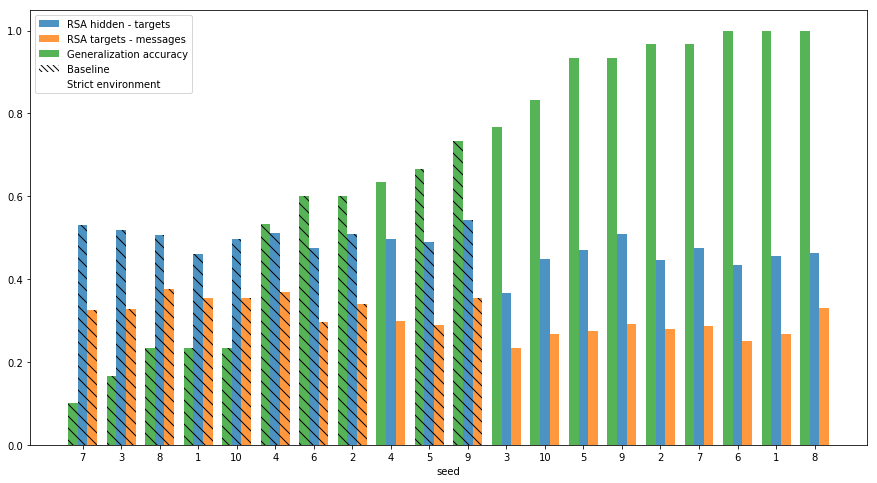

In [4]:

paths = ["runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2",
        "runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2"]

rsa = RSA(paths)

# figure stats
fig, ax = plt.subplots(figsize=(15,8))
index = np.arange(20)

# initialize empty lists
all_hidden = []
all_mess = []
all_gen = []
all_type = []
seeds = []


for i, path in enumerate(paths):

    # bar stats
    bar_width = 0.25
    opacity = 0.7
    
    # load generalization
    _, generalize = load_metrics(path)
    
    # extract data
    for s in range(1,11):
        seed = str(s)
        hidden_tar = rsa[path][seed][10000]['RSA:h_receiver/targets']
        tar_mess = rsa[path][seed][10000]['RSA:targets/messages']
        
        gen_acc = generalize[seed]['acc']
        
        all_hidden.append(hidden_tar)
        all_mess.append(tar_mess)
        all_gen.append(gen_acc)
        all_type.append(i)
        seeds.append(s)
        
# sort list by generalization        
all_gen, all_hidden, all_mess, all_type, seeds = zip(*sorted(zip(all_gen, all_hidden, all_mess, all_type, seeds)))

# need to make bars per every experiment type

# plot the bar
hiddenBar = ax.bar(index, all_hidden, bar_width,
        alpha=0.8,
        label='RSA hidden - targets')

messageBar = ax.bar(index+0.25, all_mess, bar_width,
        alpha=0.8,
        label='RSA targets - messages')

genBar = ax.bar(index-0.25, all_gen, bar_width,
        alpha=0.8,
        label='Generalization accuracy')
    
# give pattern to certain experiment setup
patterns = ('\\\\')
for i, bar in enumerate(hiddenBar):
    if all_type[i]:
        hiddenBar[i].set_hatch(patterns)
        messageBar[i].set_hatch(patterns)
        genBar[i].set_hatch(patterns)
    
#plt.title('Comparison between strict and easy environment')

plt.xlabel('seed')
plt.xticks(index, tuple([i for i in seeds]))

handles = []
# manually define a legend
handles.append(mpatches.Patch(facecolor=hiddenBar.patches[0].get_facecolor(), label = 'RSA hidden - targets'))
handles.append(mpatches.Patch(facecolor=messageBar.patches[0].get_facecolor(), label = 'RSA targets - messages'))
handles.append(mpatches.Patch(facecolor=genBar.patches[0].get_facecolor(), label = 'Generalization accuracy'))
handles.append(mpatches.Patch(facecolor='white', hatch=r'\\\\', label='Baseline'))
handles.append(mpatches.Patch(facecolor='white', label='Strict environment'))

plt.legend(handles=handles)

plt.show()
        

